In [84]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import statistics as stats
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage.filters import median_filter
import h5py
import os
from scipy.interpolate import interp1d
from matplotlib.colors import LinearSegmentedColormap

In [6]:
# load data
with h5py.File('/Volumes/LexiZ/Research/SLEAP/DreaddRotation/hdf5/D231E/D231ELT_sal1.h5.h', 'r') as f:
    dset_names = list(f.keys())
    occupancy_matrix = f['track_occupancy'][:]
    tracks_matrix = f['tracks'][:].transpose()
    nodes = [n.decode() for n in f["node_names"][:]]

frame_count, node_count, _, instance_count = tracks_matrix.shape
frame_rate = tracks_matrix.shape[0]//(29*60 + 33)  # fps(frames/sec)

# I usually just calculate framerates for the first one 
# or two videos I analyze and just plug it in for the rest of the
# videos since framerates in most cases should be the same

In [8]:
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(tracks_matrix.shape)
print()

print('===frame count===')
print(frame_count)
print()

print('===animal count===')
print(instance_count)
print()

print("===nodes===")
for i, name in enumerate(nodes):
    print(f"{i}: {name}")
print()


print('===frame rate===')
print(frame_rate, 'frames/second')
print()

===HDF5 datasets===
['node_names', 'track_names', 'track_occupancy', 'tracks']

===locations data shape===
(27004, 3, 2, 1)

===frame count===
27004

===animal count===
1

===nodes===
0: Head
1: Torso
2: Tailhead

===frame rate===
15 frames/second



# Data Cleaning and Smoothing 

In [13]:
# Fill missing values

def fill_missing(Y, kind = "cubic"):
    """Fills missing values independently along each dimension after the first"""
    initial_shape = Y.shape
    Y = Y.reshape((initial_shape[0], -1))
    # Interpolate along each side
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        Y[xq, i] = f(xq)

        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(Y)
        Y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), Y[~mask])
    # Restore to initial shape
    Y = Y.reshape(initial_shape)
    return Y

tracks_matrix = fill_missing(tracks_matrix)

### Filtering 
The purpose of filtering the coordinates is to get rid of occasional tracking errors (if they exist) as well as discretization artifacts so that we can get smooth tracking while preserving as much of the real movement as possible.

In [10]:
#Smooth

def filtered_coordinate(node_index, x_or_y, win=15, poly=3):
    """generate coordinate and smooth data with Savitzky-Golay Filter"""
    if x_or_y == 'x':
        coordinates = np.array([])
        i = 0
        while i < tracks_matrix.shape[0]:
            coordinates = np.append(coordinates, tracks_matrix[i - 1, node_index, 0, 0])
            i += 1
        return savgol_filter(coordinates, win, poly)
    if x_or_y == 'y':
        coordinates = np.array([])
        i = 0
        while i < tracks_matrix.shape[0]:
            coordinates = np.append(coordinates, tracks_matrix[i - 1, node_index, 1, 0])
            i += 1
        return savgol_filter(coordinates, win, poly)

ihead = 0
itorso = 1
itailhead = 2    
head_x_coordinates = filtered_coordinate(ihead, 'x')
head_y_coordinates = filtered_coordinate(ihead, 'y')
torso_x_coordinates = filtered_coordinate(itorso, 'x')
torso_y_coordinates = filtered_coordinate(itorso, 'y')
tailhead_x_coordinates = filtered_coordinate(itailhead, 'x')
tailhead_y_coordinates = filtered_coordinate(itailhead, 'y')

### Visualize the Smoothing Effect 

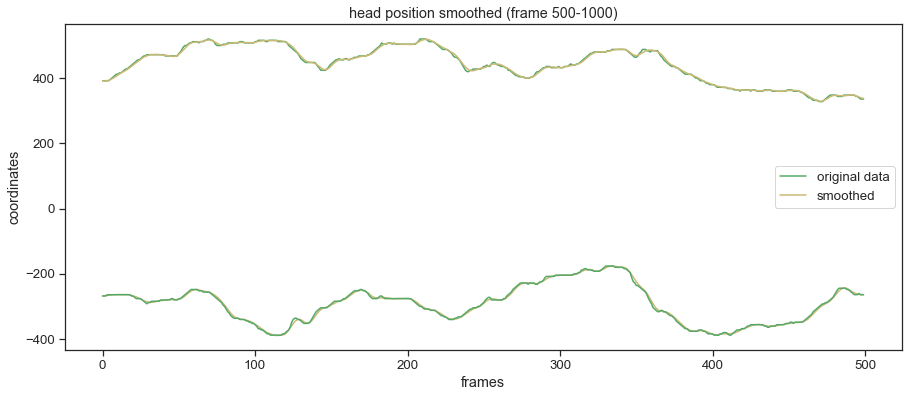

Text(0.5, 1.0, 'Thorax tracks')

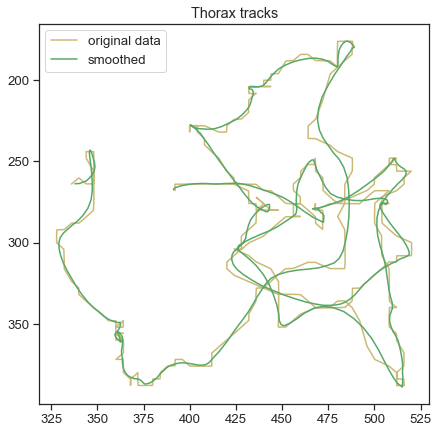

In [30]:
org_headx = tracks_matrix[:, 0, 0, :]
org_heady = tracks_matrix[:, 0, 1, :]
startframe = 500
endframe = 1000

sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

plt.figure()
plt.plot(org_headx[startframe:endframe], 'g', label='original data')
plt.plot(head_x_coordinates[startframe:endframe], 'y', label='smoothed')
plt.plot(-1*head_y_coordinates[startframe:endframe], 'y')
plt.plot(-1*org_heady[startframe:endframe], 'g')

plt.legend(loc='center right')
plt.title('head position smoothed (frame 500-1000)')
plt.ylabel('coordinates')
plt.xlabel('frames')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(org_headx[startframe:endframe],org_heady[startframe:endframe], 'y',label='original data')
plt.plot(head_x_coordinates[startframe:endframe],head_y_coordinates[startframe:endframe], 'g',label='smoothed')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Thorax tracks')

# Basic Kinematic Analysis

### Displacement

In [15]:
# Displacement is simply calculated as the euclidean distance between the coordinates of two consecutive frames

def get_displacement(node, framenum):
    if framenum == tracks_matrix.shape[0]-1:
        return 0
    else: 
        if node == 'Head':
            xd = head_x_coordinates[framenum+1] - head_x_coordinates[framenum]
            yd = head_y_coordinates[framenum+1] - head_y_coordinates[framenum]
        elif node == 'Torso':
            xd = torso_x_coordinates[framenum+1] - torso_x_coordinates[framenum]
            yd = torso_y_coordinates[framenum+1] - torso_y_coordinates[framenum]
        elif node == 'Tailhead':
            xd = tailhead_x_coordinates[framenum+1] - tailhead_x_coordinates[framenum]
            yd = tailhead_y_coordinates[framenum+1] - tailhead_y_coordinates[framenum]
        return np.sqrt(xd**2 + yd**2)
    
head_displacement = np.array([])
i = 0
for i in range(tracks_matrix.shape[0]):
    head_displacement = np.append(head_displacement, get_displacement('Head', i))
    i += 1

torso_displacement = np.array([])
i = 0
for i in range(tracks_matrix.shape[0]):
    torso_displacement = np.append(torso_displacement, get_displacement('Torso', i))
    i += 1
    
tailhead_displacement = np.array([])
i = 0
for i in range(tracks_matrix.shape[0]):
    tailhead_displacement = np.append(tailhead_displacement,get_displacement('Tailhead', i))
    i += 1

### Velocity

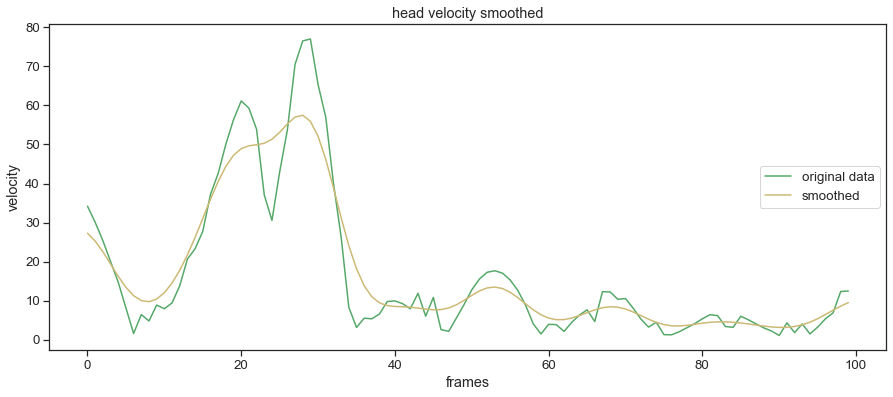

In [17]:
#velocity in coordinates/second
#smoothed with a gaussian filter with a small window size

def get_velocity(node_displacement, sigma=3):
    raw_velocity = node_displacement/(1/frame_rate)
    #smooth with gaussian filter
    filtered = gaussian_filter1d(raw_velocity, sigma)
    return filtered

head_velocity = get_velocity(head_displacement)
torso_velocity = get_velocity(torso_displacement)
tailhead_velocity = get_velocity(tailhead_displacement)

org_headv = head_displacement/(1/frame_rate)

plt.figure()
plt.plot(org_headv[200:300], 'g', label='original data')
plt.plot(head_velocity[200:300], 'y', label='smoothed')

plt.legend(loc='center right')
plt.title('head velocity smoothed')
plt.ylabel('velocity')
plt.xlabel('frames')
plt.show()

### Acceleration

In [31]:
#acceleration in coordinate/s^2
def get_acceleration(node_velocity):
    #make a matrix and is shifted by 1 frame
    nextframe = np.append(np.delete(node_velocity, 0), 0)
    return (nextframe-node_velocity)/(1/frame_rate)

head_acceleration = get_acceleration(head_velocity)
torso_acceleration = get_acceleration(torso_velocity)
tailhead_acceleration = get_acceleration(tailhead_velocity)

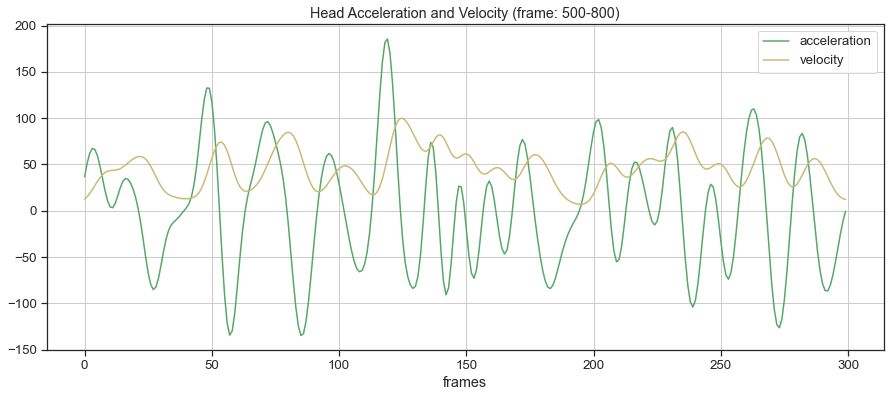

In [39]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]
startframe = 500
endframe = 800

plt.figure()
plt.plot(head_acceleration[startframe:endframe], 'g', label='acceleration')
plt.plot(head_velocity[startframe:endframe], 'y', label='velocity')
plt.title('Head Acceleration and Velocity (frame: 500-800)')
plt.xlabel('frames')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Rotation Angle and Angular Velocity

In [74]:
def get_coordinates(framenum, node):
    if node == 'Head':
        return np.array([head_x_coordinates[framenum-1], head_y_coordinates[framenum-1]])
    if node == 'Torso':
        return np.array([torso_x_coordinates[framenum-1], torso_y_coordinates[framenum-1]])
    if node == 'Tailhead':
        return np.array([tailhead_x_coordinates[framenum-1], tailhead_y_coordinates[framenum-1]])

def rotational_angle(framenum):
    """convert coordinates to egocentric coordinates by subtracting the torso coordinates from it"""
    y1 = get_coordinates(framenum, 'Head')[1] - get_coordinates(framenum, 'Torso')[1]
    y2 = get_coordinates(framenum+1, 'Head')[1] - get_coordinates(framenum, 'Torso')[1]
    x1 = get_coordinates(framenum, 'Head')[0] - get_coordinates(framenum, 'Torso')[0]
    x2 = get_coordinates(framenum+1, 'Head')[0] - get_coordinates(framenum, 'Torso')[0]
    #if the radians is negative, it means that it is in the 3rd/4th quadrant
    if math.atan2(y1, x1)<=0:
        x1y1 = 360+math.degrees(math.atan2(y1, x1))
    else: 
        x1y1 = math.degrees(math.atan2(y1, x1))
    if math.atan2(y2, x2)<=0:
        x2y2 = 360+math.degrees(math.atan2(y2, x2))
    else: 
        x2y2 = math.degrees(math.atan2(y2, x2))
    return x2y2-x1y1

#iterate through the dataset to extract rotation angle and angular velocity

#rotation angle
org_rotation_angle = []
i = 0
while i < occupancy_matrix.shape[0]:
    org_rotation_angle.append(rotational_angle(i))
    i += 1
org_rotation_angle = np.array(org_rotation_angle)

#An artifact happens when mouse turns at positive x-axis (e.g before:350degrees, after:5degrees, 5-350=-345)
rotation_angle = org_rotation_angle.copy()

def fix_outliers(Y, kind = "cubic"):
    """Fills missing values independently along each dimension after the first"""
    initial_shape = Y.shape
    Y = Y.reshape((initial_shape[0], -1))
    # Interpolate along each side
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant
        x = np.flatnonzero(~(abs(Y)>300))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill Outliers
        xq = np.flatnonzero(abs(Y)>300)
        Y[xq, i] = f(xq)

        # Fill leading or trailing outliers with the nearest values
        mask = np.isnan(Y)
        Y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), Y[~mask])
    # Restore to initial shape
    Y = Y.reshape(initial_shape)
    return Y


filtered_rotation_angle=fix_outliers(rotation_angle)
final_rotation_angle = gaussian_filter1d(filtered_rotation_angle, 3)

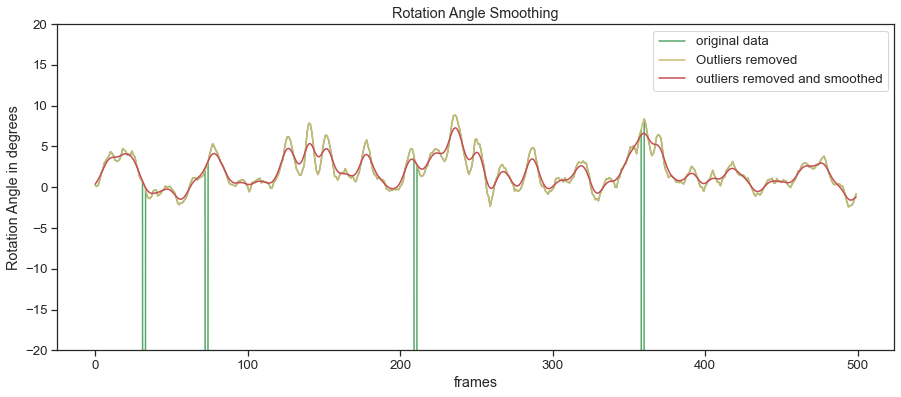

In [42]:
plt.figure()
plt.plot(org_rotation_angle[500:1000], 'g', label='original data')
plt.plot(filtered_rotation_angle[500:1000], 'y', label='Outliers removed')
plt.plot(final_rotation_angle[500:1000], 'r', label='outliers removed and smoothed')

plt.legend(loc='upper right')
plt.title('Rotation Angle Smoothing')
plt.ylabel('Rotation Angle in degrees')
plt.xlabel('frames')
plt.ylim(-20,20)
plt.show()

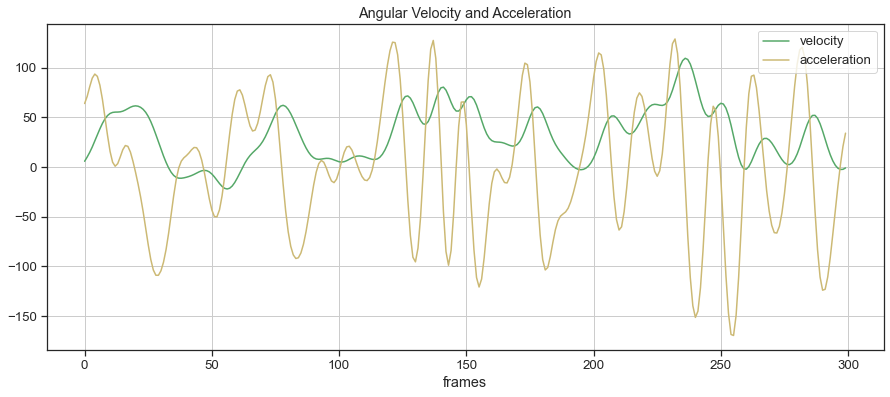

In [47]:
# angular velocity = change in degrees/sec

angular_velocity = final_rotation_angle/(1/frame_rate)

nextframe = np.append(np.delete(angular_velocity, 0), 0)
angular_acceleration = (nextframe-angular_velocity)/(1/frame_rate)

startframe = 500
endframe = 800

plt.figure()
plt.plot(angular_velocity[startframe:endframe], 'g', label='velocity')
plt.plot(angular_acceleration[startframe:endframe], 'y', label='acceleration')
plt.legend(loc='upper right')
plt.title('Angular Velocity and Acceleration')
plt.xlabel('frames')
plt.grid(True)
plt.show()

In [48]:
#convert to csv
df = pd.DataFrame({'Head xCoordinates': head_x_coordinates,
                   'Head yCoordinates': head_y_coordinates,
                   'Torso xCoordinates': torso_x_coordinates,
                   'Torso yCoordinates': torso_y_coordinates,
                   'Tailhead xCoordinates': tailhead_x_coordinates,
                   'Tailhead yCoordinates': tailhead_y_coordinates,
                   'Tailhead Displacement': tailhead_displacement,
                   'Head Velocity': head_velocity,
                   'Torso Velocity': torso_velocity,
                   'Tailhead Velocity': tailhead_velocity,
                   'Head Acceleration': head_acceleration,
                   'Angular Velocity (degrees/sec)': angular_velocity,
                   'Angular Acceleration (degrees/sec^2)': angular_acceleration,
                   'rotation angle': final_rotation_angle})
# df.to_csv('D232ERV_sal2.csv') #save file

# Rotation Bias Analysis

In [58]:
file_paths = [['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232GTT/D232GTT_cno1.csv', #0
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232GTT/D232GTT_sal1.csv'], 
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232GTT/D232GTT_cno2.csv', #1
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232GTT/D232GTT_sal2.csv'],
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ERT_cno1.csv',
               '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ERT_sal1.csv'], #2
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ERT_cno2.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ERT_sal2.csv'], #3
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ETT_cno1.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ETT_sal1.csv'], #4
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ETT_cno2.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ETT_sal2.csv'], #5
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ELT_cno1.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ELT_sal1.csv'], #6
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ELT_cno2.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D231E/D231ELT_sal2.csv'], #7
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ELT_cno1.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ELT_sal1.csv'], #8
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ELT_cno2.csv', 
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ELT_sal2.csv'], #9
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ERT_cno1.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ERT_sal1.csv'], #10
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ERT_cno2.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ERT_sal2.csv'], #11
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ERV_cno1.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ERV_sal1.csv'], #12
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ERV_cno2.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232E/D232ERV_sal2.csv'], #13
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D230G/D230GRT_cno1.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D230G/D230GRT_sal1.csv'], #14
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D230G/D230GRT_cno2.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D230G/D230GRT_sal2.csv'], #15
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D230G/D230GRV_cno1.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D230G/D230GRV_sal1.csv'], #16
              ['/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D230G/D230GRV_cno2.csv',
              '/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D230G/D230GRV_sal2.csv']] #17

In [59]:
file_index = 0 #the file you want to analyze
session_num = file_paths[file_index][0][-5]

In [60]:
session_names = []

for _ in file_paths:
    session = [i.split('/')[8].split('.')[0] for i in _]
    session_names.append(session)

session_names

[['D232GTT_cno1', 'D232GTT_sal1'],
 ['D232GTT_cno2', 'D232GTT_sal2'],
 ['D231ERT_cno1', 'D231ERT_sal1'],
 ['D231ERT_cno2', 'D231ERT_sal2'],
 ['D231ETT_cno1', 'D231ETT_sal1'],
 ['D231ETT_cno2', 'D231ETT_sal2'],
 ['D231ELT_cno1', 'D231ELT_sal1'],
 ['D231ELT_cno2', 'D231ELT_sal2'],
 ['D232ELT_cno1', 'D232ELT_sal1'],
 ['D232ELT_cno2', 'D232ELT_sal2'],
 ['D232ERT_cno1', 'D232ERT_sal1'],
 ['D232ERT_cno2', 'D232ERT_sal2'],
 ['D232ERV_cno1', 'D232ERV_sal1'],
 ['D232ERV_cno2', 'D232ERV_sal2'],
 ['D230GRT_cno1', 'D230GRT_sal1'],
 ['D230GRT_cno2', 'D230GRT_sal2'],
 ['D230GRV_cno1', 'D230GRV_sal1'],
 ['D230GRV_cno2', 'D230GRV_sal2']]

In [80]:
fig_file = os.path.abspath('/Volumes/LexiZ/research/SLEAP/DreaddRotation/Figures/' + 
                           str(session_names[file_index][0].split('_')[0]) + 
                           '/' +
                           str(session_names[file_index][0].split('_')[0]) + 
                           '_session'+str(session_num))
#where you want to save the figures to
fig_file

'/Volumes/LexiZ/research/SLEAP/DreaddRotation/Figures/D232GTT/D232GTT_session1'

#### The first five frames and the last frame is deleted to exclude unstable video capturing (the first few frames are usually kind of funky). 

In [62]:
#CNO
CNO = pd.read_csv(file_paths[file_index][0]) #where your csv files are
print(file_paths[file_index][0])
CNO = CNO.rename(columns={'Unnamed: 0': 'Frame', 'Angular Velocity (radians/sec)': 'Angular Velocity (degrees/sec)'})[5:-1].reset_index().drop(['index'], axis=1)
CNO

/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232GTT/D232GTT_cno1.csv


,Frame,Head xCoordinates,Head yCoordinates,Torso xCoordinates,Torso yCoordinates,Tailhead xCoordinates,Tailhead yCoordinates,Tailhead Displacement,Head Velocity,Torso Velocity,Tailhead Velocity,Head Acceleration,Angular Velocity (degrees/sec),Angular Acceleration (degrees/sec^2),rotation angle
0,5,274.654583,363.280238,264.650598,319.092283,238.228332,302.742939,4.378956,223.070139,171.972641,176.452874,-821.362699,-188.559260,1193.037310,-12.570617
1,6,276.787989,365.534198,264.143447,323.247180,240.379596,306.557033,4.432960,168.312626,140.464451,156.553904,-618.855672,-109.023439,609.873949,-7.268229
2,7,282.174359,363.459419,265.583928,324.606001,244.540285,308.086674,19.282636,127.055581,115.032019,139.272751,-455.149284,-68.365176,274.912652,-4.557678
3,8,293.120884,361.535525,275.684461,331.068492,260.912284,318.273810,20.034692,96.712295,93.632632,121.798558,-339.074945,-50.037666,153.869715,-3.335844
4,9,293.945050,353.341442,266.896229,318.873775,248.702352,302.389653,2.234327,74.107299,74.470804,102.610930,-259.516608,-39.779685,151.146161,-2.651979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27025,27030,422.307554,235.998242,396.009029,279.997497,395.988940,311.960822,0.000508,2.889923,0.023000,0.012022,-4.359127,-0.898830,-7.166414,-0.059922
27026,27031,422.041267,235.999621,396.010135,279.997709,395.989247,311.960417,0.000235,2.599314,0.025433,0.011764,-4.962978,-1.376591,-3.149627,-0.091773
27027,27032,421.799129,236.001212,396.011652,279.998375,395.989480,311.960444,0.000564,2.268449,0.027689,0.011801,-4.972989,-1.586566,-0.110919,-0.105771
27028,27033,421.622130,236.002886,396.013645,279.999570,395.989598,311.960996,0.001172,1.936917,0.029423,0.012007,-4.074564,-1.593960,1.348173,-0.106264


In [63]:
#saline
saline = pd.read_csv(file_paths[file_index][1]) #where your csv files are
print(file_paths[file_index][1])
saline = saline.rename(columns={'Unnamed: 0': 'Frame', 'Angular Velocity (radians/sec)': 'Angular Velocity (degrees/sec)'})[5:-1].reset_index().drop(['index'], axis=1)
saline

/Volumes/LexiZ/research/SLEAP/DreaddRotation/DR CSV/D232GTT/D232GTT_sal1.csv


,Frame,Head xCoordinates,Head yCoordinates,Torso xCoordinates,Torso yCoordinates,Tailhead xCoordinates,Tailhead yCoordinates,Tailhead Displacement,Head Velocity,Torso Velocity,Tailhead Velocity,Head Acceleration,Angular Velocity (degrees/sec),Angular Acceleration (degrees/sec^2),rotation angle
0,5,398.656000,244.481986,389.484989,280.369221,376.811876,302.890621,11.063109,51.899854,261.971895,221.329473,45.142216,6.691640,1.244306,0.446109
1,6,399.720140,241.659107,380.392332,286.350458,369.406752,311.109898,8.556402,54.909335,226.636346,195.751064,50.430958,6.774594,-83.253498,0.451640
2,7,400.503748,239.224272,375.100088,291.042941,364.872882,318.366346,17.502260,58.271399,193.723691,170.897115,48.235665,1.224361,-133.317252,0.081624
3,8,402.477346,235.571166,356.245229,300.658954,352.405716,330.650436,16.601048,61.487110,161.806236,146.022264,37.749558,-7.663456,-149.837981,-0.510897
4,9,398.545818,237.208852,380.287756,292.316608,367.677343,324.141043,5.556816,64.003747,130.591363,121.224192,22.057610,-17.652655,-140.306424,-1.176844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27025,27030,422.307554,235.998242,396.009029,279.997497,395.988940,311.960822,0.000508,6.035169,1.245542,2.245107,-30.082170,-1.841680,-3.197767,-0.122779
27026,27031,422.041267,235.999621,396.010135,279.997709,395.989247,311.960417,0.000235,4.029691,0.582954,1.026824,-17.562904,-2.054864,0.825832,-0.136991
27027,27032,421.799129,236.001212,396.011652,279.998375,395.989480,311.960444,0.000564,2.858831,0.258199,0.430235,-10.533944,-1.999809,3.209650,-0.133321
27028,27033,421.622130,236.002886,396.013645,279.999570,395.989598,311.960996,0.001172,2.156568,0.115326,0.167387,-6.272767,-1.785832,3.018951,-0.119055


#### Since we are going to classify frames into moving versus non-moving states and only use moving frames to calculate rotation bias, raw rotation bias is calculated just for sanity checks later. 

In [66]:
raw_sal_left_turns = saline[saline['rotation angle'] < 0].shape[0]
raw_sal_right_turns = saline[saline['rotation angle'] > 0].shape[0]
raw_sal_percent_right_turns = raw_sal_right_turns/saline.shape[0]
raw_sal_percent_left_turns = raw_sal_left_turns/saline.shape[0]

raw_CNO_left_turns = CNO[CNO['rotation angle'] < 0].shape[0]
raw_CNO_right_turns = CNO[CNO['rotation angle'] > 0].shape[0]
raw_CNO_percent_right_turns = raw_CNO_right_turns/CNO.shape[0]
raw_CNO_percent_left_turns = raw_CNO_left_turns/CNO.shape[0]

# Adding a column to indicate right(1)/left(-1) turn.
CNO['binaryleftright(right1)'] = CNO['rotation angle']/np.abs(CNO['rotation angle'])
CNO

,Frame,Head xCoordinates,Head yCoordinates,Torso xCoordinates,Torso yCoordinates,Tailhead xCoordinates,Tailhead yCoordinates,Tailhead Displacement,Head Velocity,Torso Velocity,Tailhead Velocity,Head Acceleration,Angular Velocity (degrees/sec),Angular Acceleration (degrees/sec^2),rotation angle,binaryleftright(right1)
0,5,274.654583,363.280238,264.650598,319.092283,238.228332,302.742939,4.378956,223.070139,171.972641,176.452874,-821.362699,-188.559260,1193.037310,-12.570617,-1.0
1,6,276.787989,365.534198,264.143447,323.247180,240.379596,306.557033,4.432960,168.312626,140.464451,156.553904,-618.855672,-109.023439,609.873949,-7.268229,-1.0
2,7,282.174359,363.459419,265.583928,324.606001,244.540285,308.086674,19.282636,127.055581,115.032019,139.272751,-455.149284,-68.365176,274.912652,-4.557678,-1.0
3,8,293.120884,361.535525,275.684461,331.068492,260.912284,318.273810,20.034692,96.712295,93.632632,121.798558,-339.074945,-50.037666,153.869715,-3.335844,-1.0
4,9,293.945050,353.341442,266.896229,318.873775,248.702352,302.389653,2.234327,74.107299,74.470804,102.610930,-259.516608,-39.779685,151.146161,-2.651979,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27025,27030,422.307554,235.998242,396.009029,279.997497,395.988940,311.960822,0.000508,2.889923,0.023000,0.012022,-4.359127,-0.898830,-7.166414,-0.059922,-1.0
27026,27031,422.041267,235.999621,396.010135,279.997709,395.989247,311.960417,0.000235,2.599314,0.025433,0.011764,-4.962978,-1.376591,-3.149627,-0.091773,-1.0
27027,27032,421.799129,236.001212,396.011652,279.998375,395.989480,311.960444,0.000564,2.268449,0.027689,0.011801,-4.972989,-1.586566,-0.110919,-0.105771,-1.0
27028,27033,421.622130,236.002886,396.013645,279.999570,395.989598,311.960996,0.001172,1.936917,0.029423,0.012007,-4.074564,-1.593960,1.348173,-0.106264,-1.0


Text(0.5, 1.0, 'CNO Head Tracks Colored by Direction of Rotation')

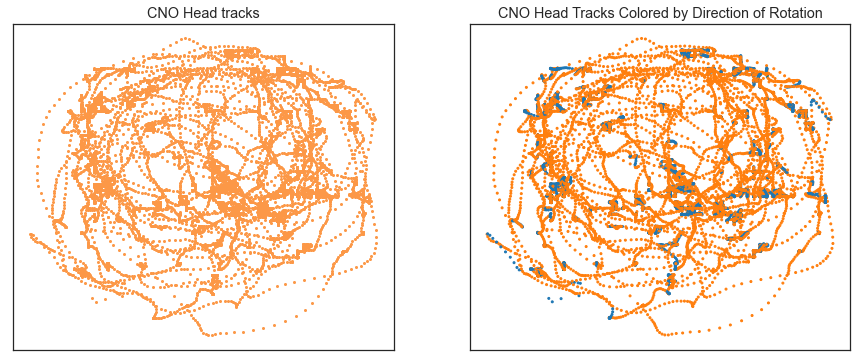

In [67]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.scatter(CNO['Head xCoordinates'], CNO['Head yCoordinates'], s=4, color='#fc9847')
ax1.set_xticks([])
ax1.set_yticks([])
plt.gca().invert_yaxis()
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_title('CNO Head tracks')

kp = CNO['binaryleftright(right1)']
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(CNO['Head xCoordinates'], CNO['Head yCoordinates'], c=kp, cmap='tab20', s=4, vmin=vmin, vmax=vmax)
ax2.set_xticks([])
ax2.set_yticks([])
plt.gca().invert_yaxis()
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_title('CNO Head Tracks Colored by Direction of Rotation')

Text(0.5, 1.0, 'saline Head Tracks Colored by Direction of Rotation')

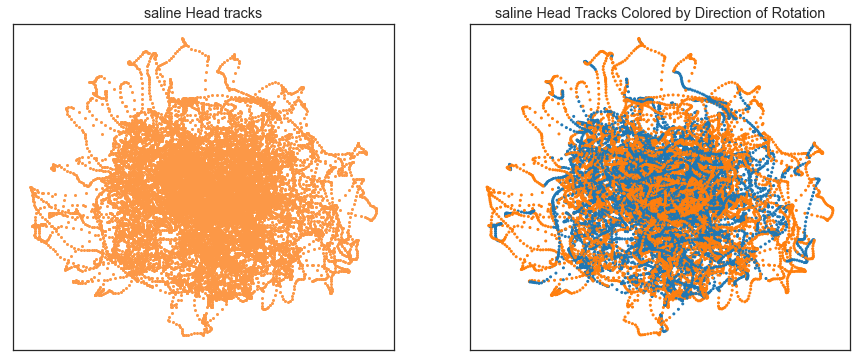

In [68]:
saline['binaryleftright(right1)'] = saline['rotation angle']/np.abs(saline['rotation angle'])

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.scatter(saline['Head xCoordinates'], saline['Head yCoordinates'], s=4, color='#fc9847')
ax1.set_xticks([])
ax1.set_yticks([])
plt.gca().invert_yaxis()
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_title('saline Head tracks')

kp = saline['binaryleftright(right1)'] 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(saline['Head xCoordinates'], saline['Head yCoordinates'], c=kp, cmap='tab20', s=4, vmin=vmin, vmax=vmax)
ax2.set_xticks([])
ax2.set_yticks([])
plt.gca().invert_yaxis()
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_title('saline Head Tracks Colored by Direction of Rotation')

# Moving Versus Non-Moving

### This is mainly to get rid of frames where the animal is staying still or grooming.

In [72]:
def moving_or_not(s):
    '''
    Add a column that indicates if for a given frame the animal is moving or not, and if so towards which direction 
    1: right turn
    0: not moving
    -1: left turn
    
    tailhead_threshold & rot_ang_threshold: below what value do you not want to count as the animal is moving
    sig_rot_ang_threshold: above waht value do you think is considered a significant rotation that we want to save
                            regardless of if the animal is moving its entire body(low tailhead displacement)
    '''
    s = s.copy()
    tailhead_threshold = 0.4
    rot_ang_threshold = 0.5
    sig_rot_ang_threshold = 2
    s['rotating?'] = np.zeros(s.shape[0])
    for i in range(s.shape[0]):
        if ((s['Tailhead Displacement'].iloc[i] > tailhead_threshold) & 
            (np.abs(s['rotation angle'].iloc[i]) > rot_ang_threshold)) | (np.abs(s['rotation angle'].iloc[i]) > sig_rot_ang_threshold):
            s['rotating?'].iloc[i]=s['binaryleftright(right1)'].iloc[i]
        else:
            s['rotating?'].iloc[i]=0
    return s

labeled_CNO = moving_or_not(CNO)
labeled_saline = moving_or_not(saline)
# labeled_CNO.to_csv('labeled_CNO1_D231ELT.csv')

labeled_CNO_rotating = labeled_CNO[labeled_CNO['rotating?']!=0]
perc_cno_rotating = "{:.1%}".format(round(labeled_CNO[labeled_CNO['rotating?']!=0].shape[0]/labeled_CNO.shape[0], 3))
# labeled_CNO_rotating.to_csv('filename')
'''
if you want to generate a csv file that only contains rotating/moving frames
'''

labeled_saline_rotating = labeled_saline[labeled_saline['rotating?']!=0]
perc_sal_rotating = "{:.1%}".format(round(labeled_saline[labeled_saline['rotating?']!=0].shape[0]/labeled_CNO.shape[0], 3))
# labeled_saline_rotating.to_csv('filename')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [73]:
labeled_CNO

,Frame,Head xCoordinates,Head yCoordinates,Torso xCoordinates,Torso yCoordinates,Tailhead xCoordinates,Tailhead yCoordinates,Tailhead Displacement,Head Velocity,Torso Velocity,Tailhead Velocity,Head Acceleration,Angular Velocity (degrees/sec),Angular Acceleration (degrees/sec^2),rotation angle,binaryleftright(right1),rotating?
0,5,274.654583,363.280238,264.650598,319.092283,238.228332,302.742939,4.378956,223.070139,171.972641,176.452874,-821.362699,-188.559260,1193.037310,-12.570617,-1.0,-1.0
1,6,276.787989,365.534198,264.143447,323.247180,240.379596,306.557033,4.432960,168.312626,140.464451,156.553904,-618.855672,-109.023439,609.873949,-7.268229,-1.0,-1.0
2,7,282.174359,363.459419,265.583928,324.606001,244.540285,308.086674,19.282636,127.055581,115.032019,139.272751,-455.149284,-68.365176,274.912652,-4.557678,-1.0,-1.0
3,8,293.120884,361.535525,275.684461,331.068492,260.912284,318.273810,20.034692,96.712295,93.632632,121.798558,-339.074945,-50.037666,153.869715,-3.335844,-1.0,-1.0
4,9,293.945050,353.341442,266.896229,318.873775,248.702352,302.389653,2.234327,74.107299,74.470804,102.610930,-259.516608,-39.779685,151.146161,-2.651979,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27025,27030,422.307554,235.998242,396.009029,279.997497,395.988940,311.960822,0.000508,2.889923,0.023000,0.012022,-4.359127,-0.898830,-7.166414,-0.059922,-1.0,0.0
27026,27031,422.041267,235.999621,396.010135,279.997709,395.989247,311.960417,0.000235,2.599314,0.025433,0.011764,-4.962978,-1.376591,-3.149627,-0.091773,-1.0,0.0
27027,27032,421.799129,236.001212,396.011652,279.998375,395.989480,311.960444,0.000564,2.268449,0.027689,0.011801,-4.972989,-1.586566,-0.110919,-0.105771,-1.0,0.0
27028,27033,421.622130,236.002886,396.013645,279.999570,395.989598,311.960996,0.001172,1.936917,0.029423,0.012007,-4.074564,-1.593960,1.348173,-0.106264,-1.0,0.0


### One observation: For sessions with bigger rotation bias, animal tends to be less active (more frames classified as non-moving)
#### Outside of the redlines are frames that are classified as "moving". 

Text(0.5, 1.0, 'Saline')

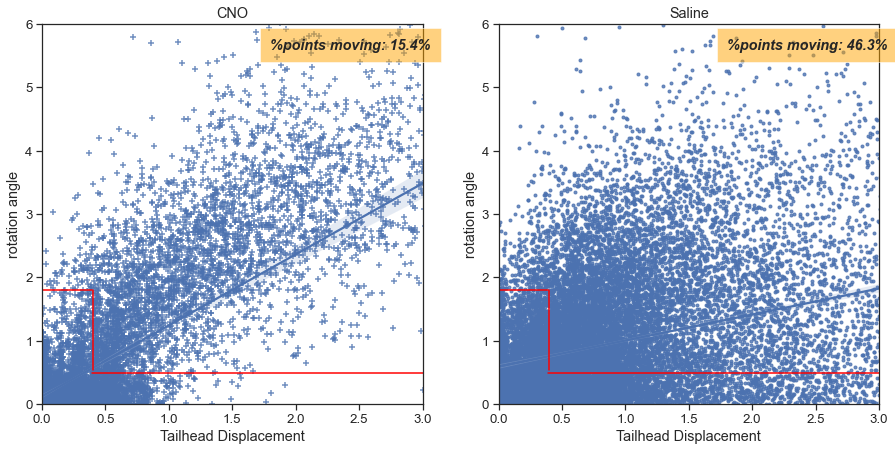

In [77]:
from sklearn.linear_model import LinearRegression

c_CNO = CNO.copy()
c_CNO['rotation angle'] = np.abs(c_CNO['rotation angle'])

fig=plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
sns.regplot(x='Tailhead Displacement', y='rotation angle', data=c_CNO, marker="+")
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 6)
ax1.axvline(x=0.4, ymin=0.09, ymax=0.3, color='red')
ax1.axhline(y=1.8, xmin=0, xmax=0.13, color='red')
ax1.axhline(y=0.5, xmin=0.13, xmax=max(c_CNO['Tailhead Displacement']), color='red')
ax1.text(1.8, 5.6, '%points moving: '+str(perc_cno_rotating), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10},  fontweight='bold')
ax1.set_title('CNO')

c_sal = saline.copy()
c_sal['rotation angle'] = np.abs(c_sal['rotation angle'])

reg = LinearRegression().fit(np.array(c_sal['rotation angle']).reshape((-1,1)), 
                             np.array(c_sal['Tailhead Displacement']))
# print('intercept:', reg.intercept_)
# print('slope:', reg.coef_[0])
r_sq = reg.score(np.array(c_sal['rotation angle']).reshape((-1,1)), 
                             np.array(c_sal['Tailhead Displacement']))
# print('coefficient of determination:', r_sq)

ax2 = fig.add_subplot(122)
sns.regplot(x='Tailhead Displacement', y='rotation angle', data=c_sal, marker=".")
ax2.set_xlim(0, 3)
ax2.set_ylim(0, 6)
ax2.axvline(x=0.4, ymin=0.09, ymax=0.3, color='red')
ax2.axhline(y=1.8, xmin=0, xmax=0.13, color='red')
ax2.axhline(y=0.5, xmin=0.13, xmax=max(c_sal['Tailhead Displacement']), color='red')
ax2.text(1.8, 5.6, '%points moving: '+str(perc_sal_rotating), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10},  fontweight='bold')
ax2.set_title('Saline')

## Visualize Rotation Bias for CNO and Saline

Text(0.5, 1.0, 'rotational bias (unfiltered)')

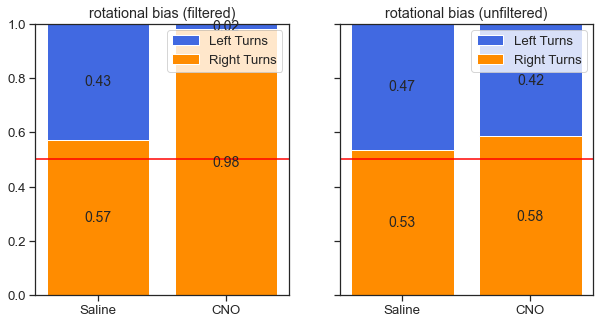

In [81]:
# Values of each group
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
names = ['Saline','CNO']
r=[0,1]


labeled_left_turns = labeled_CNO_rotating[labeled_CNO_rotating['rotation angle'] < 0].shape[0]
labeled_right_turns = labeled_CNO_rotating[labeled_CNO_rotating['rotation angle'] > 0].shape[0]
labeled_CNO_percent_right_turns = labeled_right_turns/labeled_CNO_rotating.shape[0]
labeled_CNO_percent_left_turns = labeled_left_turns/labeled_CNO_rotating.shape[0]
labeled_left_turns = labeled_saline_rotating[labeled_saline_rotating['rotation angle'] < 0].shape[0]
labeled_right_turns = labeled_saline_rotating[labeled_saline_rotating['rotation angle'] > 0].shape[0]
labeled_saline_percent_right_turns = labeled_right_turns/labeled_saline_rotating.shape[0]
labeled_saline_percent_left_turns = labeled_left_turns/labeled_saline_rotating.shape[0]

ax1.bar(0, labeled_saline_percent_right_turns, color='darkorange', edgecolor='white')
ax1.bar(0, labeled_saline_percent_left_turns, bottom=labeled_saline_percent_right_turns, color='royalblue', edgecolor='white', label='Left Turns')
ax1.bar(1, labeled_CNO_percent_right_turns, color='darkorange', edgecolor='white', label='Right Turns')
ax1.bar(1, labeled_CNO_percent_left_turns, bottom=labeled_CNO_percent_right_turns, color='royalblue', edgecolor='white')

# .patches is everything inside of the chart
for rect in ax1.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{round(height, 2)}'  # f'{height:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2

    # plot only when height is greater than specified value
    if height > 0:
        ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=14)

ax1.legend(loc='upper right')
ax1.axhline([0.5], color='red')
ax1.set_ylim(0, 1)
ax1.set_xticks(r)
ax1.set_xticklabels(names)
ax1.set_title('rotational bias (filtered)')

'-------------------------------------------------------'

raw_saline_right = raw_sal_percent_right_turns
raw_saline_left = raw_sal_percent_left_turns
raw_CNO_right = raw_CNO_percent_right_turns
raw_CNO_left = raw_CNO_percent_left_turns

ax2.bar(0, raw_saline_right, color='darkorange', edgecolor='white')
ax2.bar(0, raw_saline_left, bottom=raw_saline_right, color='royalblue', edgecolor='white', label='Left Turns')
ax2.bar(1, raw_CNO_right, color='darkorange', edgecolor='white', label='Right Turns')
ax2.bar(1, raw_CNO_left, bottom=raw_CNO_right, color='royalblue', edgecolor='white')


for rect in ax2.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    label_text = f'{round(height, 2)}'  # f'{height:.2f}' to format decimal values
    label_x = x + width / 2
    label_y = y + height / 2
    if height > 0:
        ax2.text(label_x, label_y, label_text, ha='center', va='center', fontsize=14)
        
ax2.legend(loc='upper right')
ax2.axhline([0.5], color='red')
ax2.set_ylim(0, 1)
ax2.set_xticks(r)
ax2.set_xticklabels(names)
ax2.set_title('rotational bias (unfiltered)')

# fig.savefig(fig_file + '/rotation bias')

#### Blue: Left, Green: Not Moving, Orange: Right

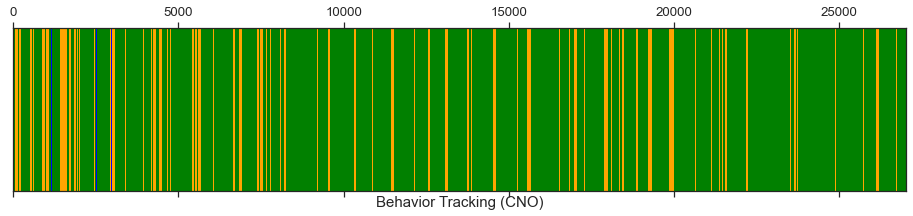

In [87]:
data = labeled_CNO['rotating?'].astype('int').tolist()

fig, ax = plt.subplots(figsize=(16, 3))
cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'green', 'orange'])
ax.matshow([data], aspect="auto", cmap=cmap, vmin=-1, vmax=1)
plt.xlabel('Behavior Tracking (CNO)', fontsize=15)
ax.set_yticks([])             
plt.show()

# fig.savefig(fig_file + '/bt(cno)')

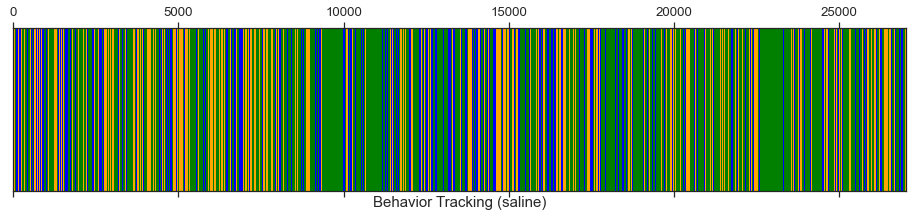

In [88]:
data = labeled_saline['rotating?'].astype('int').tolist()

fig, ax = plt.subplots(figsize=(16, 3))
cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'green', 'orange'])
ax.matshow([data], aspect="auto", cmap=cmap, vmin=-1, vmax=1)
ax.set_yticks([])       
plt.xlabel('Behavior Tracking (saline)', fontsize=15)
plt.show()

fig.savefig(fig_file + '/bt(saline)')

### Updated version of a previously shown figure
#### Blue: Left, Green: Not Moving, Orange: Right

Text(0.5, 1.0, 'CNO Head Tracks Colored by Direction of Rotation')

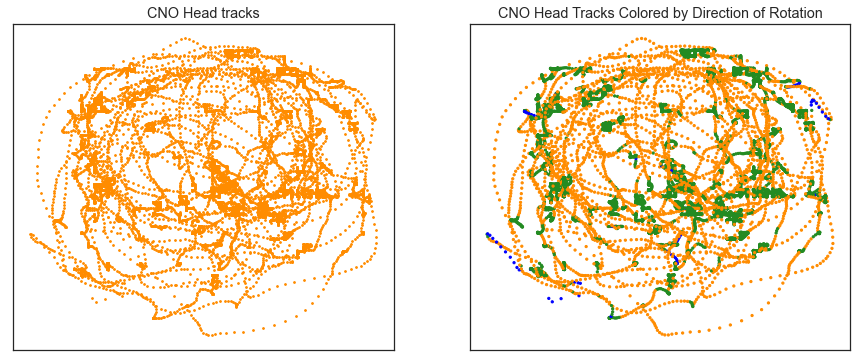

In [91]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.scatter(labeled_CNO['Head xCoordinates'], labeled_CNO['Head yCoordinates'], s=3, color='darkorange')
ax1.set_xticks([])
ax1.set_yticks([])
plt.gca().invert_yaxis()
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_title('CNO Head tracks')

kp = labeled_CNO['rotating?'].astype('int').tolist()

ax2 = fig.add_subplot(122)
cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'forestgreen', 'darkorange'])
ax2.scatter(labeled_CNO['Head xCoordinates'], labeled_CNO['Head yCoordinates'], c=kp, cmap=cmap, s=5, vmin=-1, vmax=1)
ax2.set_xticks([])
ax2.set_yticks([])
plt.gca().invert_yaxis()
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_title('CNO Head Tracks Colored by Direction of Rotation')

# fig.savefig(fig_file + '/CNO Headtracks')

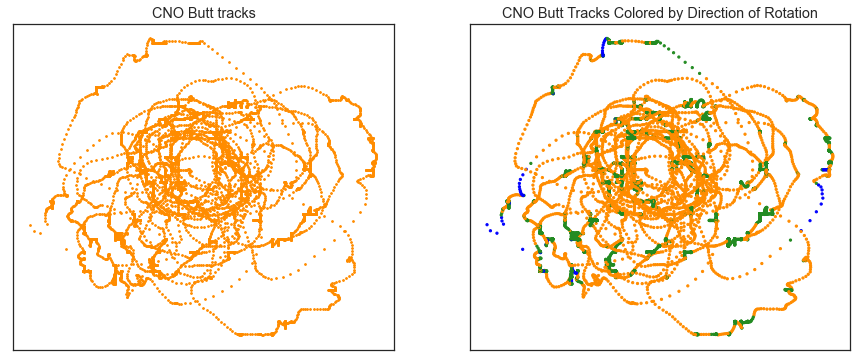

In [92]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.scatter(labeled_CNO['Tailhead xCoordinates'], labeled_CNO['Tailhead yCoordinates'], s=3, color='darkorange')
ax1.set_xticks([])
ax1.set_yticks([])
plt.gca().invert_yaxis()
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_title('CNO Butt tracks')

kp = labeled_CNO['rotating?'].astype('int').tolist()

ax2 = fig.add_subplot(122)
cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'forestgreen', 'darkorange'])
ax2.scatter(labeled_CNO['Tailhead xCoordinates'], labeled_CNO['Tailhead yCoordinates'], c=kp, cmap=cmap, s=5, vmin=-1, vmax=1)
ax2.set_xticks([])
ax2.set_yticks([])
plt.gca().invert_yaxis()
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_title('CNO Butt Tracks Colored by Direction of Rotation')

fig.savefig(fig_file + '/CNO Butttracks')

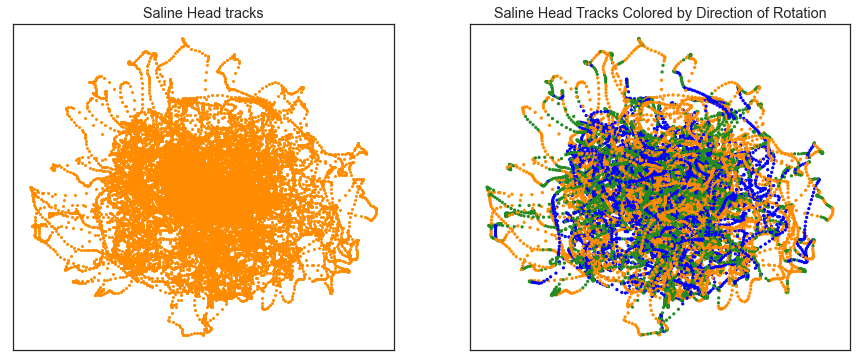

In [93]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.scatter(labeled_saline['Head xCoordinates'], labeled_saline['Head yCoordinates'], s=4, color='darkorange')
ax1.set_xticks([])
ax1.set_yticks([])
plt.gca().invert_yaxis()
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_title('Saline Head tracks')

kp = labeled_saline['rotating?'].astype('int').tolist()

ax2 = fig.add_subplot(122)
cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'forestgreen', 'darkorange'])
ax2.scatter(labeled_saline['Head xCoordinates'], labeled_saline['Head yCoordinates'], c=kp, cmap=cmap, s=5, vmin=-1, vmax=1)
ax2.set_xticks([])
ax2.set_yticks([])
plt.gca().invert_yaxis()
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_title('Saline Head Tracks Colored by Direction of Rotation')

fig.savefig(fig_file + '/Saline Headtracks')

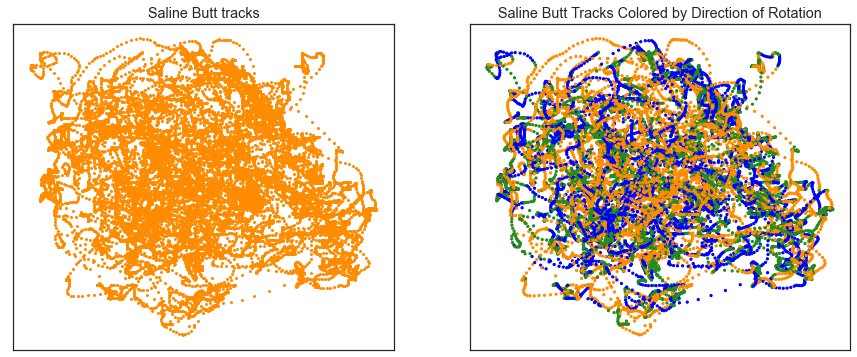

In [94]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.scatter(labeled_saline['Tailhead xCoordinates'], labeled_saline['Tailhead yCoordinates'], s=4, color='darkorange')
ax1.set_xticks([])
ax1.set_yticks([])
plt.gca().invert_yaxis()
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_title('Saline Butt tracks')

kp = labeled_saline['rotating?'].astype('int').tolist()

ax2 = fig.add_subplot(122)
cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'forestgreen', 'darkorange'])
ax2.scatter(labeled_saline['Tailhead xCoordinates'], labeled_saline['Tailhead yCoordinates'], c=kp, cmap=cmap, s=5, vmin=-1, vmax=1)
ax2.set_xticks([])
ax2.set_yticks([])
plt.gca().invert_yaxis()
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_title('Saline Butt Tracks Colored by Direction of Rotation')

fig.savefig(fig_file + '/Saline Butttracks')